In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd

In [3]:
%matplotlib inline
import matplotlib.pylab as plt

In [4]:
data_path = "/home/wm/Playground/IdealOps/batch_jobs/data/"

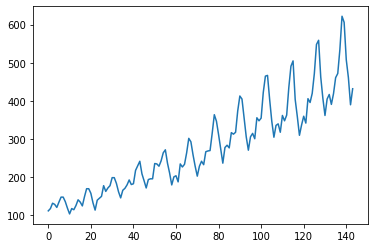

In [5]:
df = pd.read_csv(data_path + 'international-airline-passengers.csv', sep = ";")
plt.plot(np.arange(df.shape[0]), df["Passengers"])
plt.show()

In [43]:
import os
from itertools import combinations

In [14]:
def preprocess_raw_data(file_path:str)->dict:
    '''
    Parameters
    ---------------
    file path to file

    Returns
    --------------
    data_standard_api: data format as we defined
    '''
    df = pd.read_json(file_path, \
                  encoding="utf-8", \
                  orient='records')

    data_standard_api = dict()
    dg = df.groupby(["系统名称", "任务名称"])
    system = df["系统名称"].unique()
    for system_id in system:
        task_list = df[df["系统名称"] == system_id]["任务名称"].unique()
        for task_id in task_list:
            tem = dg.get_group((system_id, task_id))
            data_standard_api["{}_{}".format(system_id, task_id)] = list(zip(tem["开始时间"].tolist(),\
                                                                tem["完成时间"].tolist()))
    return data_standard_api

class data_processing():
    def __init__(self, data_standard_api, aimed_ts):
        self.ts = data_standard_api
        self.color_option = ["r", "g", "b", "y", "m", "k"]
        self.aimed_ts = aimed_ts


    def extract_time_series(self)->dict:
        ts_dict = dict()
        for k, v in data_standard_api.items():
            tem = pd.Series([pd.to_datetime(i[1]) - pd.to_datetime(i[0])
                             for i in v]).dt.total_seconds() / 60
            tem.index = [pd.to_datetime(i[0]) for i in v]
            ts_dict[k] = tem
            
        return ts_dict

        
    def visualize_time_series(self, figure_dir, ts_dict:dict, filename:str):
        '''
        Parameters 
        -------
        ts_list: a list of time series which should be the return of extract_time_series
        filename: specify the file name to save the figure

        Returns 
        -------
        None
        '''
        # sample ts 
        fig, ax_array = plt.subplots(6, sharex=True)
        fig.set_size_inches(10, 6, 9)
        fig.subplots_adjust(hspace=0.4)
        color = iter(["r", "g", "b", "y", "m", "k"])
        i = 0
        for key, value in ts_dict.items():
            if i > 5:
                break
            else:
                _ = value.plot(ax=ax_array[i], color = next(color))
                _ = ax_array[i].set_title('{}'.format(key))
                _ = ax_array[i].set_ylabel('Min')
                _ = ax_array[i].set_xlabel('start time')
                i += 1

        plt.savefig('{}{}.png'.format(figure_dir, filename), format='png', dpi=300)
        plt.close()


    def resample_unevenly_distributed_time_series(self, ts_dict:dict)->list:
        '''
        Parameters:
        ------------
        ts_list: a list of unevenly sampled time series
        
        Returns
        --------------
        ts_dict_new: a list of evenly sampled time series
        '''
        #make all the ts have equal length as ts indexed as ts_index

        
        # throw away the shorter ones than ts indexed as ts_index
        #interval = 1664 = 1day plus 3 h and 44 min drove me nuts
        tem_len = ts_dict[self.aimed_ts].shape[0]

        preserved_ts_dict = {k: v for k, v in ts_dict.items() if (v.shape[0] / tem_len > 0.8)}

        inteval = int(preserved_ts_dict[self.aimed_ts].max()) + 1

        ts_dict_tem = {k: v.resample("{} Min".format(inteval)).mean() \
                       for k, v in preserved_ts_dict.items()}

        ts_dict_new_len = ts_dict_tem[self.aimed_ts].shape[0]
        ts_dict_tem_1 = {k: v[:ts_dict_new_len] for k, v in ts_dict_tem.items()}

        for k, v in ts_dict_tem_1.items():
            if v.shape[0] < ts_dict_new_len:
                ps_len = ts_dict_new_len - v.shape[0]
                tem_ps = pd.Series([np.nan] * ps_len)
                tem_ps.index = ts_dict_tem_1[self.aimed_ts].index[-ps_len:]
                ts_dict_tem_1[k] = ts_dict_tem_1[k].combine(tem_ps, max)

        ts_dict_new = {k: v.ffill() for k, v in ts_dict_tem_1.items()}        
        return ts_dict_new

In [15]:
data_path

'/home/wm/Playground/IdealOps/batch_jobs/data/data_sample/'

In [16]:
ls /home/wm/Playground/IdealOps/batch_jobs/data/data_sample/

beta_abrupt_change.json              norm_trend_abrupt_change.json
beta_cycle_abrupt_change.json        norm_trend.json
beta_cycle_trend_abrupt_change.json  norm_with_noise.json
beta_cycle_trend.json                powerlog_abrupt_change.json
beta_trend_abrupt_change.json        powerlog_cycle_abrupt_change.json
beta_trend.json                      powerlog_cycle_trend_abrupt_change.json
beta_with_noise.json                 powerlog_cycle_trend.json
norm_abrupt_change.json              powerlog_trend_abrupt_change.json
norm_cycle_abrupt_change.json        powerlog_trend.json
norm_cycle_trend_abrupt_change.json  powerlog_with_noise.json
norm_cycle_trend.json


In [17]:
data_path = "/home/wm/Playground/IdealOps/batch_jobs/data/data_sample/"
file = "norm_cycle_trend.json"
data_standard_api = preprocess_raw_data(data_path + file)

In [20]:
aimed_ts = "system_01_task_04"
dp = data_processing(data_standard_api, aimed_ts)
ts_dict = dp.extract_time_series()
ts_dict_new = dp.resample_unevenly_distributed_time_series(ts_dict)  

In [21]:
dataset = ts_dict_new[aimed_ts].values.astype('float32')

In [22]:
dataset = dataset.reshape(-1, 1);
dataset.shape

(125, 1)

In [51]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=0)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: ', testScore)

83 42


/home/wm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train Score:  1315.872341579861
Test Score:  6756.073046875


In [31]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredict.shape

(40, 1)

In [40]:
dataset[:4]

array([[220.35443],
       [185.48523],
       [219.755  ],
       [239.18968]], dtype=float32)

In [50]:
trainPredict[:4]
trainPredictPlot[:4]
testPredict[:5]

array([[226.02643],
       [190.69409],
       [225.41902],
       [245.11182]], dtype=float32)

array([[      nan],
       [226.02643],
       [190.69409],
       [225.41902]], dtype=float32)

array([[1381.8208],
       [1373.3617],
       [1470.0538],
       [1500.6836],
       [1545.4447]], dtype=float32)

<Figure size 1080x360 with 0 Axes>

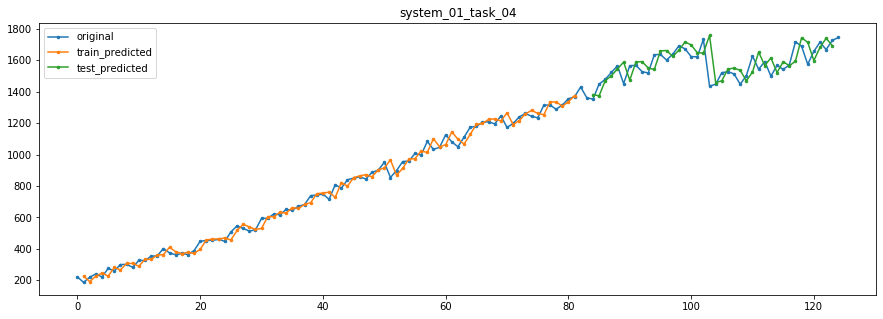

In [47]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
plt.figure(figsize=(15,5))
# plot baseline and predictions
_ = plt.plot(dataset, label = "original", marker = ".", markersize=5)
_ = plt.plot(trainPredictPlot, label = "train_predicted", marker = ".", markersize = 5)
_ = plt.plot(testPredictPlot, label = "test_predicted", marker = ".", markersize=5)
_ = plt.title(aimed_ts)
_ = plt.legend()
_ = plt.show()   

In [52]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], [ ] 
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

np.random.seed(7)

In [91]:
dataset[1:3,0]
train[:3]
trainX[:4]
trainY[:]
train[-3:]
trainX[-3:]

array([118., 132.], dtype=float32)

array([[112.],
       [118.],
       [132.]], dtype=float32)

array([[112.],
       [118.],
       [132.],
       [129.]], dtype=float32)

array([118., 132., 129., 121., 135., 148., 148., 136., 119., 104., 118.,
       115., 126., 141., 135., 125., 149., 170., 170., 158., 133., 114.,
       140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
       146., 166., 171., 180., 193., 181., 183., 218., 230., 242., 209.,
       191., 172., 194., 196., 196., 236., 235., 229., 243., 264., 272.,
       237., 211., 180., 201., 204., 188., 235., 227., 234., 264., 302.,
       293., 259., 229., 203., 229., 242., 233., 267., 269., 270., 315.,
       364., 347., 312., 274., 237., 278., 284., 277., 317., 313., 318.,
       374., 413., 405., 355., 306., 271.], dtype=float32)

array([[306.],
       [271.],
       [306.]], dtype=float32)

array([[405.],
       [355.],
       [306.]], dtype=float32)

In [75]:
train.shape
trainX.shape
trainY.shape
test.shape
testX.shape
testY.shape

(96, 1)

(94, 1)

(94,)

(48, 1)

(46, 1)

(46,)

In [101]:
print(*dataset)

[112.] [118.] [132.] [129.] [121.] [135.] [148.] [148.] [136.] [119.] [104.] [118.] [115.] [126.] [141.] [135.] [125.] [149.] [170.] [170.] [158.] [133.] [114.] [140.] [145.] [150.] [178.] [163.] [172.] [178.] [199.] [199.] [184.] [162.] [146.] [166.] [171.] [180.] [193.] [181.] [183.] [218.] [230.] [242.] [209.] [191.] [172.] [194.] [196.] [196.] [236.] [235.] [229.] [243.] [264.] [272.] [237.] [211.] [180.] [201.] [204.] [188.] [235.] [227.] [234.] [264.] [302.] [293.] [259.] [229.] [203.] [229.] [242.] [233.] [267.] [269.] [270.] [315.] [364.] [347.] [312.] [274.] [237.] [278.] [284.] [277.] [317.] [313.] [318.] [374.] [413.] [405.] [355.] [306.] [271.] [306.] [315.] [301.] [356.] [348.] [355.] [422.] [465.] [467.] [404.] [347.] [305.] [336.] [340.] [318.] [362.] [348.] [363.] [435.] [491.] [505.] [404.] [359.] [310.] [337.] [360.] [342.] [406.] [396.] [420.] [472.] [548.] [559.] [463.] [407.] [362.] [405.] [417.] [391.] [419.] [461.] [472.] [535.] [622.] [606.] [508.] [461.] [390.]

In [99]:
pd.DataFrame({"testX":testX.reshape(-1), "testY": testY})

,testX,testY
0,315.0,301.0
1,301.0,356.0
2,356.0,348.0
3,348.0,355.0
4,355.0,422.0
5,422.0,465.0
6,465.0,467.0
7,467.0,404.0
8,404.0,347.0
9,347.0,305.0


In [97]:
pd.DataFrame({"X":trainX.reshape(-1), "Y": trainY})

,X,Y
0,112.0,118.0
1,118.0,132.0
2,132.0,129.0
3,129.0,121.0
4,121.0,135.0
...,...,...
89,374.0,413.0
90,413.0,405.0
91,405.0,355.0
92,355.0,306.0


In [54]:
data_path = "/home/wm/Playground/IdealOps/batch_jobs/data/"
df = pd.read_csv(data_path + 'international-airline-passengers.csv',
                 sep=";",
                 usecols=[1],
                 engine='python')

array([118.], dtype=float32)

In [55]:
dataset = df.values
type(dataset)
dataset = dataset.astype('float32')
type(dataset)

numpy.ndarray

numpy.ndarray

In [56]:
dataset.shape

(144, 1)

In [57]:
from keras.models import Sequential
from keras.layers import Dense

In [65]:
dataset = df.values.astype('float32')

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=0)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: ', testScore)

96 48


/home/wm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train Score:  533.0702345827792
Test Score:  2360.265433933424


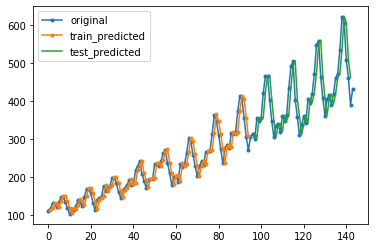

In [66]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
_ = plt.plot(dataset, label = "original", marker = ".")
_ = plt.plot(trainPredictPlot, label = "train_predicted", marker = ".")
_ = plt.plot(testPredictPlot, label = "test_predicted")
_ = plt.legend()
_ = plt.show()